In [1]:
import numpy as np
from scipy.optimize import fsolve
import sympy as sm
import sympy.physics.mechanics as mec
from pydy.system import System
from pydy.viz import Sphere, Cylinder, VisualizationFrame, Scene

In [2]:
class ReferenceFrame(mec.ReferenceFrame):
   """Subclass that enforces the desired unit vector indice style."""

   def __init__(self, *args, **kwargs):

      kwargs.pop('indices', None)
      kwargs.pop('latexs', None)

      lab = args[0].lower()
      tex = r'\hat{{{}}}_{}'

      super(ReferenceFrame, self).__init__(*args,
                                             indices=('1', '2', '3'),
                                             latexs=(tex.format(lab, '1'),
                                                   tex.format(lab, '2'),
                                                   tex.format(lab, '3')),
                                             **kwargs)

In [3]:
N = ReferenceFrame('N')
A = ReferenceFrame('A')
B = ReferenceFrame('B')
C = ReferenceFrame('C')
D = ReferenceFrame('D')
E = ReferenceFrame('E')
F = ReferenceFrame('F')

In [4]:
q1, q2, q3, q4 = mec.dynamicsymbols('q1 q2 q3 q4')
q5, q6, q7, q8 = mec.dynamicsymbols('q5 q6 q7 q8')

u1, u2, u3, u4 = mec.dynamicsymbols('u1 u2 u3 u4')
u5, u6, u7, u8 = mec.dynamicsymbols('u5 u6 u7 u8')

In [5]:
# rear frame yaw
A.orient(N, 'Axis', (q3, N['3']))
# rear frame roll
B.orient(A, 'Axis', (q4, A['1']))
# rear frame pitch
C.orient(B, 'Axis', (q5, B['2']))
# front frame steer
E.orient(C, 'Axis', (q7, C['3']))

In [6]:
rf, rr = sm.symbols('rf rr')
d1, d2, d3 = sm.symbols('d1 d2 d3')
l1, l2, l3, l4 = sm.symbols('l1 l2 l3 l4')

# acceleration due to gravity
g = sm.symbols('g')

# mass
mc, md, me, mf = sm.symbols('mc md me mf')

# inertia
ic11, ic22, ic33, ic31 = sm.symbols('ic11 ic22 ic33 ic31')
id11, id22 = sm.symbols('id11 id22')
ie11, ie22, ie33, ie31 = sm.symbols('ie11 ie22 ie33 ie31')
if11, if22 = sm.symbols('if11 if22')

In [7]:
T4, T6, T7 = mec.dynamicsymbols('T4 T6 T7')

In [8]:
# rear wheel contact point
dn = mec.Point('dn')

# rear wheel contact point to rear wheel center
do = mec.Point('do')
do.set_pos(dn, -rr * B['3'])

# rear wheel center to bicycle frame center
co = mec.Point('co')
co.set_pos(do, l1 * C['1'] + l2 * C['3'])

# rear wheel center to steer axis point
ce = mec.Point('ce')
ce.set_pos(do, d1 * C['1'])

# steer axis point to the front wheel center
fo = mec.Point('fo')
fo.set_pos(ce, d2 * E['3'] + d3 * E['1'])

# front wheel center to front frame center
eo = mec.Point('eo')
eo.set_pos(fo, l3 * E['1'] + l4 * E['3'])

# locate the point fixed on the wheel which instantaneously touches the
# ground
fn = mec.Point('fn')
fn.set_pos(fo, rf * E['2'].cross(A['3']).cross(E['2']).normalize())

In [9]:
holonomic = fn.pos_from(dn).dot(A['3'])

In [10]:
mec.find_dynamicsymbols(holonomic)

{q4(t), q5(t), q7(t)}

In [11]:
t = mec.dynamicsymbols._t

kinematical = [q3.diff(t) - u3,  # yaw
               q4.diff(t) - u4,  # roll
               q5.diff(t) - u5,  # pitch
               q7.diff(t) - u7]  # steer

In [12]:
A.set_ang_vel(N, u3 * N['3'])  # yaw rate
B.set_ang_vel(A, u4 * A['1'])  # roll rate
C.set_ang_vel(B, u5 * B['2'])  # pitch rate
D.set_ang_vel(C, u6 * C['2'])  # rear wheel rate
E.set_ang_vel(C, u7 * C['3'])  # steer rate
F.set_ang_vel(E, u8 * E['2'])  # front wheel rate

In [13]:
# rear wheel contact stays in ground plane and does not slip
dn.set_vel(N, 0.0 * N['1'])

# mass centers
do.v2pt_theory(dn, N, D)
co.v2pt_theory(do, N, C)
ce.v2pt_theory(do, N, C)
fo.v2pt_theory(ce, N, E)
eo.v2pt_theory(fo, N, E)

# wheel contact velocities
fn.v2pt_theory(fo, N, F);  # supress output

In [14]:
nonholonomic = [
    fn.vel(N).dot(A['1']),
    fn.vel(N).dot(A['3']),
    fn.vel(N).dot(A['2']),
]

In [15]:
Ic = mec.inertia(C, ic11, ic22, ic33, 0.0, 0.0, ic31)
Id = mec.inertia(C, id11, id22, id11, 0.0, 0.0, 0.0)
Ie = mec.inertia(E, ie11, ie22, ie33, 0.0, 0.0, ie31)
If = mec.inertia(E, if11, if22, if11, 0.0, 0.0, 0.0)

In [16]:
rear_frame = mec.RigidBody('Rear Frame', co, C, mc, (Ic, co))
rear_wheel = mec.RigidBody('Rear Wheel', do, D, md, (Id, do))
front_frame = mec.RigidBody('Front Frame', eo, E, me, (Ie, eo))
front_wheel = mec.RigidBody('Front Wheel', fo, F, mf, (If, fo))

bodies = [rear_frame, rear_wheel, front_frame, front_wheel]

In [17]:
# gravity
Fco = (co, mc*g*A['3'])
Fdo = (do, md*g*A['3'])
Feo = (eo, me*g*A['3'])
Ffo = (fo, mf*g*A['3'])

# input torques
Tc = (C, T4*A['1'] - T6*B['2'] - T7*C['3'])
Td = (D, T6*C['2'])
Te = (E, T7*C['3'])

loads = [Fco, Fdo, Feo, Ffo, Tc, Td, Te]

In [18]:
kane = mec.KanesMethod(N,
                       [q3, q4, q7],  # yaw, roll, steer
                       [u4, u6, u7],  # roll rate, rear wheel rate, steer rate
                       kd_eqs=kinematical,
                       q_dependent=[q5],  # pitch angle
                       configuration_constraints=[holonomic],
                       u_dependent=[u3, u5, u8],  # yaw rate, pitch rate, front wheel rate
                       velocity_constraints=nonholonomic)

fr, frstar = kane.kanes_equations(bodies, loads)

In [19]:
from pydy.system import System
sys = System(kane)

In [20]:
sys.constants = {
   rf: 0.35,
   rr: 0.3,
   d1: 0.9534570696121849,
   d3: 0.03207142672761929,
   d2: 0.2676445084476887,
   l1: 0.4707271515135145,
   l2: -0.47792881146460797,
   l4: -0.3699518200282974,
   l3: -0.00597083392418685,
   mc: 85.0,
   md: 2.0,
   me: 4.0,
   mf: 3.0,
   id11: 0.0603,
   id22: 0.12,
   if11: 0.1405,
   if22: 0.28,
   ic11: 7.178169776497895,
   ic22: 11.0,
   ic31: 3.8225535938357873,
   ic33: 4.821830223502103,
   ie11: 0.05841337700152972,
   ie22: 0.06,
   ie31: 0.009119225261946298,
   ie33: 0.007586622998470264,
   g: 9.81
}

In [21]:
initial_speed = 4.6  # m/s
initial_roll_rate = 0.5  # rad/s

In [22]:
eval_holonomic = sm.lambdify((q5, q4, q7, d1, d2, d3, rf, rr), holonomic)
initial_pitch_angle = float(fsolve(eval_holonomic, 0.0,
                                   args=(0.0,  # q4
                                         1e-8,  # q7
                                         sys.constants[d1],
                                         sys.constants[d2],
                                         sys.constants[d3],
                                         sys.constants[rf],
                                         sys.constants[rr])))
np.rad2deg(initial_pitch_angle)

18.000000000000007

In [23]:
sys.initial_conditions = {q3: 0.0,
                          q4: 0.0,
                          q5: initial_pitch_angle,
                          q7: 1e-8,
                          u3: 0.0,
                          u4: initial_roll_rate,
                          u5: 0.0,
                          u6: -initial_speed/sys.constants[rr],
                          u7: 0.0,
                          u8: -initial_speed/sys.constants[rf]}

In [24]:
fps = 30  # frames per second
duration = 6.0  # seconds
sys.times = np.linspace(0.0, duration, num=int(duration*fps))

In [25]:
sys.generate_ode_function(generator='cython')

x_trajectory = sys.integrate()

In [26]:
holonomic_vs_time  = eval_holonomic(x_trajectory[:, 3],  # q5
                                    x_trajectory[:, 1],  # q4
                                    x_trajectory[:, 2],  # q7
                                    sys.constants[d1],
                                    sys.constants[d2],
                                    sys.constants[d3],
                                    sys.constants[rf],
                                    sys.constants[rr])

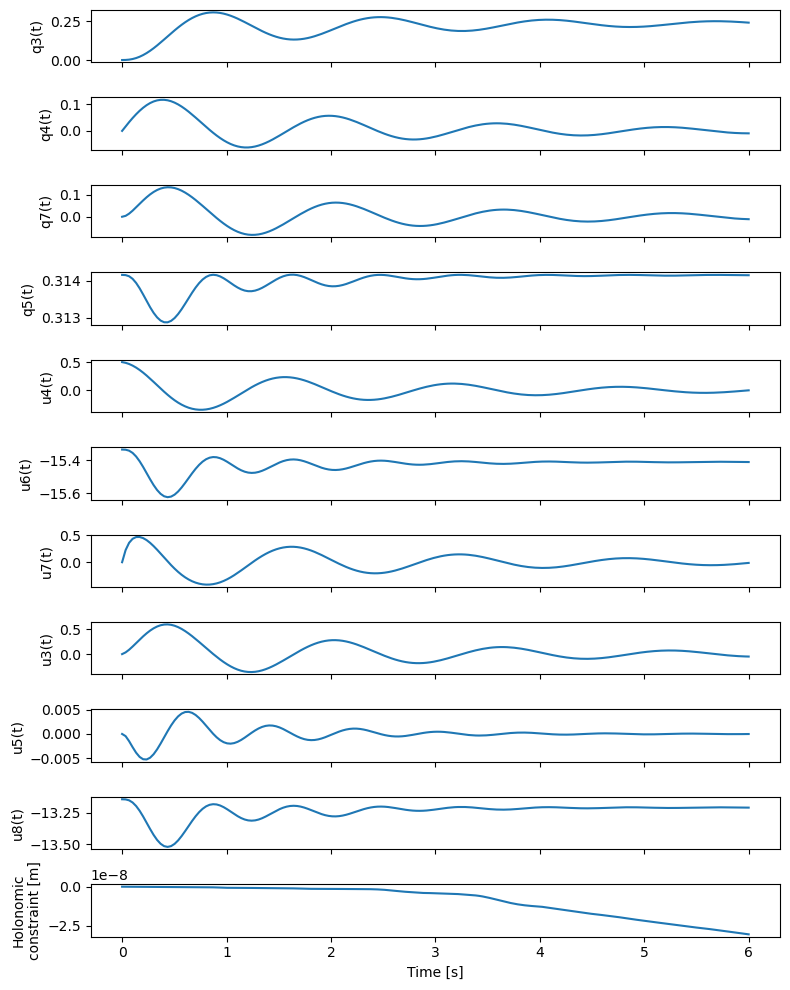

In [27]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(len(sys.states) + 1, 1, sharex=True)
fig.set_size_inches(8, 10)
for ax, traj, s in zip(axes, x_trajectory.T, sys.states):
    ax.plot(sys.times, traj)
    ax.set_ylabel(s)
axes[-1].plot(sys.times, np.squeeze(holonomic_vs_time))
axes[-1].set_ylabel('Holonomic\nconstraint [m]')
axes[-1].set_xlabel('Time [s]')
plt.tight_layout()

In [28]:
rear_wheel_circle = Cylinder(radius=sys.constants[rr], length=0.01,
                             color="green", name='rear wheel')
front_wheel_circle = Cylinder(radius=sys.constants[rf], length=0.01,
                              color="green", name='front wheel')
rear_wheel_vframe = VisualizationFrame(B, do, rear_wheel_circle)
front_wheel_vframe = VisualizationFrame(E, fo, front_wheel_circle)

In [29]:
d1_cylinder = Cylinder(radius=0.02, length=sys.constants[d1],
                       color='black', name='rear frame d1')
d2_cylinder = Cylinder(radius=0.02, length=sys.constants[d2],
                       color='black', name='front frame d2')
d3_cylinder = Cylinder(radius=0.02, length=sys.constants[d3],
                       color='black', name='front frame d3')

d1_frame = VisualizationFrame(C.orientnew('C_r', 'Axis', (sm.pi/2, C.z)),
                              do.locatenew('d1_half', d1/2*C.x), d1_cylinder)
d2_frame = VisualizationFrame(E.orientnew('E_r', 'Axis', (-sm.pi/2, E.x)),
                              fo.locatenew('d2_half', -d3*E.x - d2/2*E.z), d2_cylinder)
d3_frame = VisualizationFrame(E.orientnew('E_r', 'Axis', (sm.pi/2, E.z)),
                              fo.locatenew('d3_half', -d3/2*E.x), d3_cylinder)

In [30]:
co_sphere = Sphere(radius=0.05, color='blue', name='rear frame co')
eo_sphere = Sphere(radius=0.05, color='blue', name='rear frame eo')
co_frame = VisualizationFrame(C, co, co_sphere)
eo_frame = VisualizationFrame(E, eo, eo_sphere)

In [31]:
scene = Scene(N, dn, system=sys)
scene.visualization_frames = [front_wheel_vframe, rear_wheel_vframe,
                              d1_frame, d2_frame, d3_frame,
                              co_frame, eo_frame]

In [32]:
scene.display_jupyter(axes_arrow_length=5.0)